In [206]:
import pandas as pd
import numpy as np

df = pd.read_csv("current-data-on-the-geographic-distribution-of-covid-19-cases-worldwide.csv")
df.head()

,daterep,day,month,year,cases,deaths,countriesandterritories,geoid,countryterritorycode,popdata2018,continentexp
0,NaN,28,4,2020,172,0,Afghanistan,AF,AFG,37172386.0,Asia
1,NaN,27,4,2020,68,10,Afghanistan,AF,AFG,37172386.0,Asia
2,NaN,26,4,2020,112,4,Afghanistan,AF,AFG,37172386.0,Asia
3,NaN,25,4,2020,70,1,Afghanistan,AF,AFG,37172386.0,Asia
4,NaN,24,4,2020,105,2,Afghanistan,AF,AFG,37172386.0,Asia


### Distribution of Cases Worldwide

We need to match format of countries to that of the country names in the geojson file. This involves replacing underscores with whitespaces and removing territories not included in json file

In [207]:
#Replace underscore with whitespace
for index in range(0, len(df)):
    country = df.iloc[index][6]
    no_ = country.replace("_", " ")
    df.at[index, "countriesandterritories"] = no_

#Too much missing data for Turkey
df = df.loc[np.where(df["countriesandterritories"] != "Turkey")]
    
#Group data by country
data = df.loc[:, ("countriesandterritories", "cases")]
data.dropna(axis = 0, inplace = True)
total_cases = data[["countriesandterritories", "cases"]].groupby("countriesandterritories").sum().reset_index()

#GeoJson Data
geo_data = pd.read_json("world_countries.geojson")

#Obtain list of countries from json file
countries = []
for index in range(0, len(geo_data)):
    country = geo_data.iloc[index][1]["properties"]["name"]
    if country not in countries:
        countries.append(country)

#Set country to NaN if not in json data
for index in range(0, len(total_cases)):
    country = total_cases.iloc[index][0]
    if country not in countries:
        total_cases.at[index, "countriesandterritories"] = float('NaN')

#Drop Nan to give final set of countries compatible with json file
total_cases.dropna(axis = 0, inplace = True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(total_cases)

              countriesandterritories   cases
0                         Afghanistan    1703
1                             Albania     736
2                             Algeria    3517
4                              Angola      27
7                           Argentina    3990
8                             Armenia    1867
10                          Australia    6725
11                            Austria   15256
12                         Azerbaijan    1678
15                         Bangladesh    5913
17                            Belarus   11289
18                            Belgium   46687
19                             Belize      18
20                              Benin      64
22                             Bhutan       7
23                            Bolivia    1014
25             Bosnia and Herzegovina    1564
26                           Botswana      22
27                             Brazil   66501
30                           Bulgaria    1363
31                       Burkina F

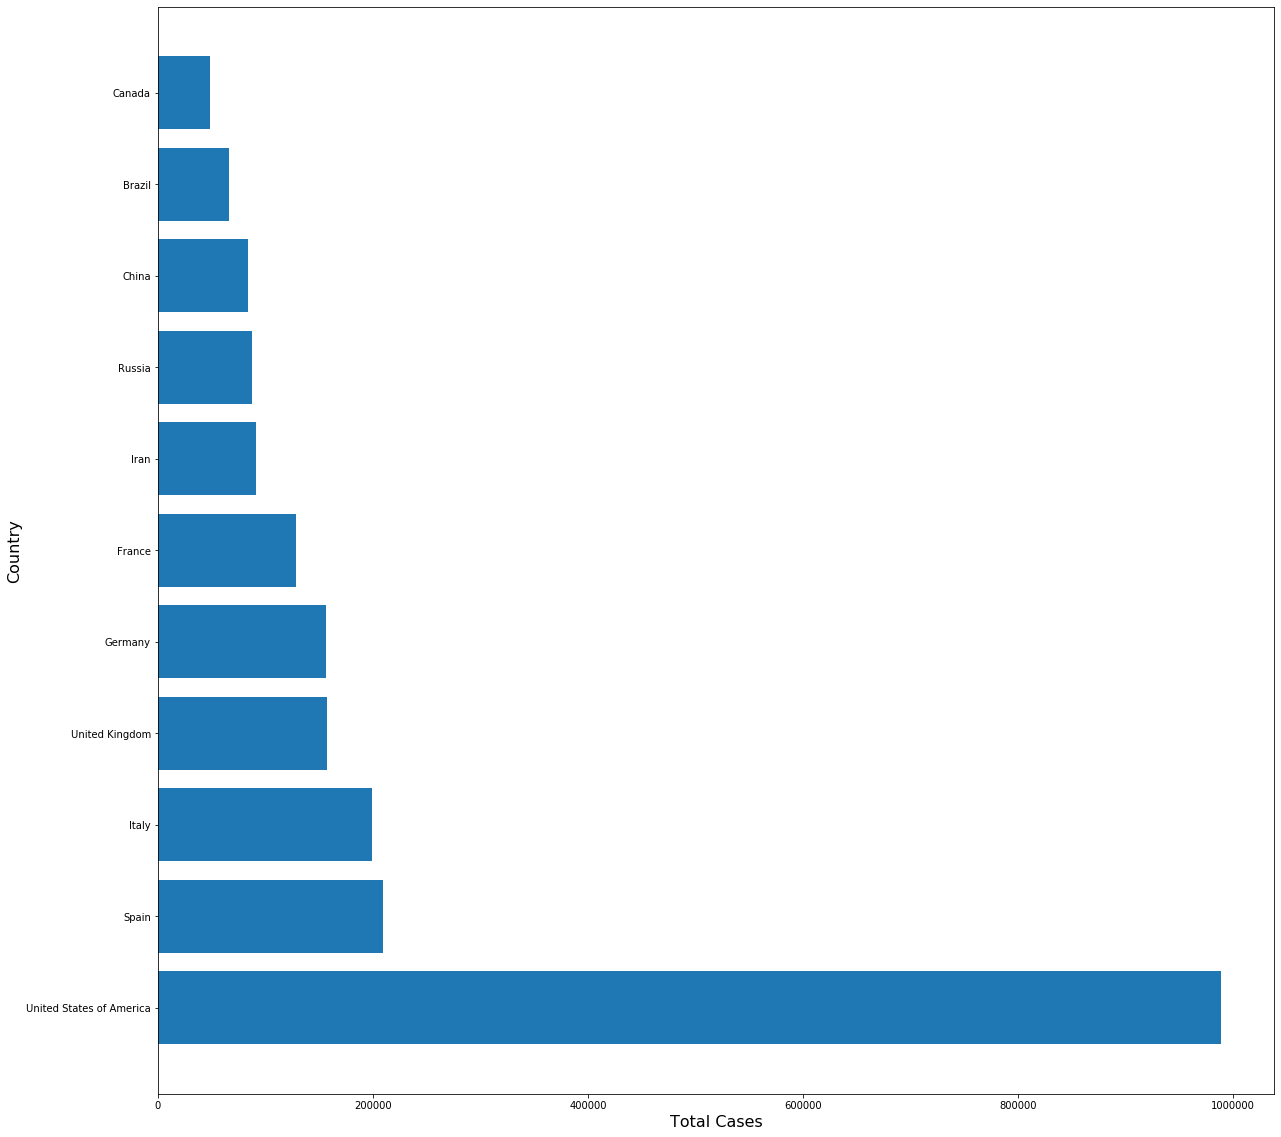

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

#10 Highest Case Countries
ten_highest = total_cases.sort_values("cases", ascending = False).reset_index().loc[:10]

plt.barh(ten_highest["countriesandterritories"], ten_highest["cases"])
plt.ylabel("Country", fontsize=16)  
plt.xlabel("Total Cases", fontsize=16)  
plt.show()

In [213]:
import folium

world_map = folium.Map(location=[30, 30], zoom_start = 1.5)
world_geo = r'world_countries.geojson'

world_map.choropleth(
    geo_data=world_geo,
    data=total_cases,
    columns=['countriesandterritories', 'cases'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name = 'Confirmed Cases',
    threshold_scale = [1000, 10000, 50000, 100000.0, 250000.0, 1000000.0] # max 6 for some reason?
)

world_map.save("world_cases_2020_28_4.html")
world_map

In [210]:
ten_countries = ten_highest["countriesandterritories"].values

#Dictionary of dataframes
ten_countries_data = {}
for country in ten_countries:
    ten_countries_data[country] = df[df.loc[:]["countriesandterritories"] == country].iloc[::-1].reset_index()
    #Add cummulative count of cases
    ten_countries_data[country]["Cumulative Count"] = ten_countries_data[country]["cases"].cumsum()

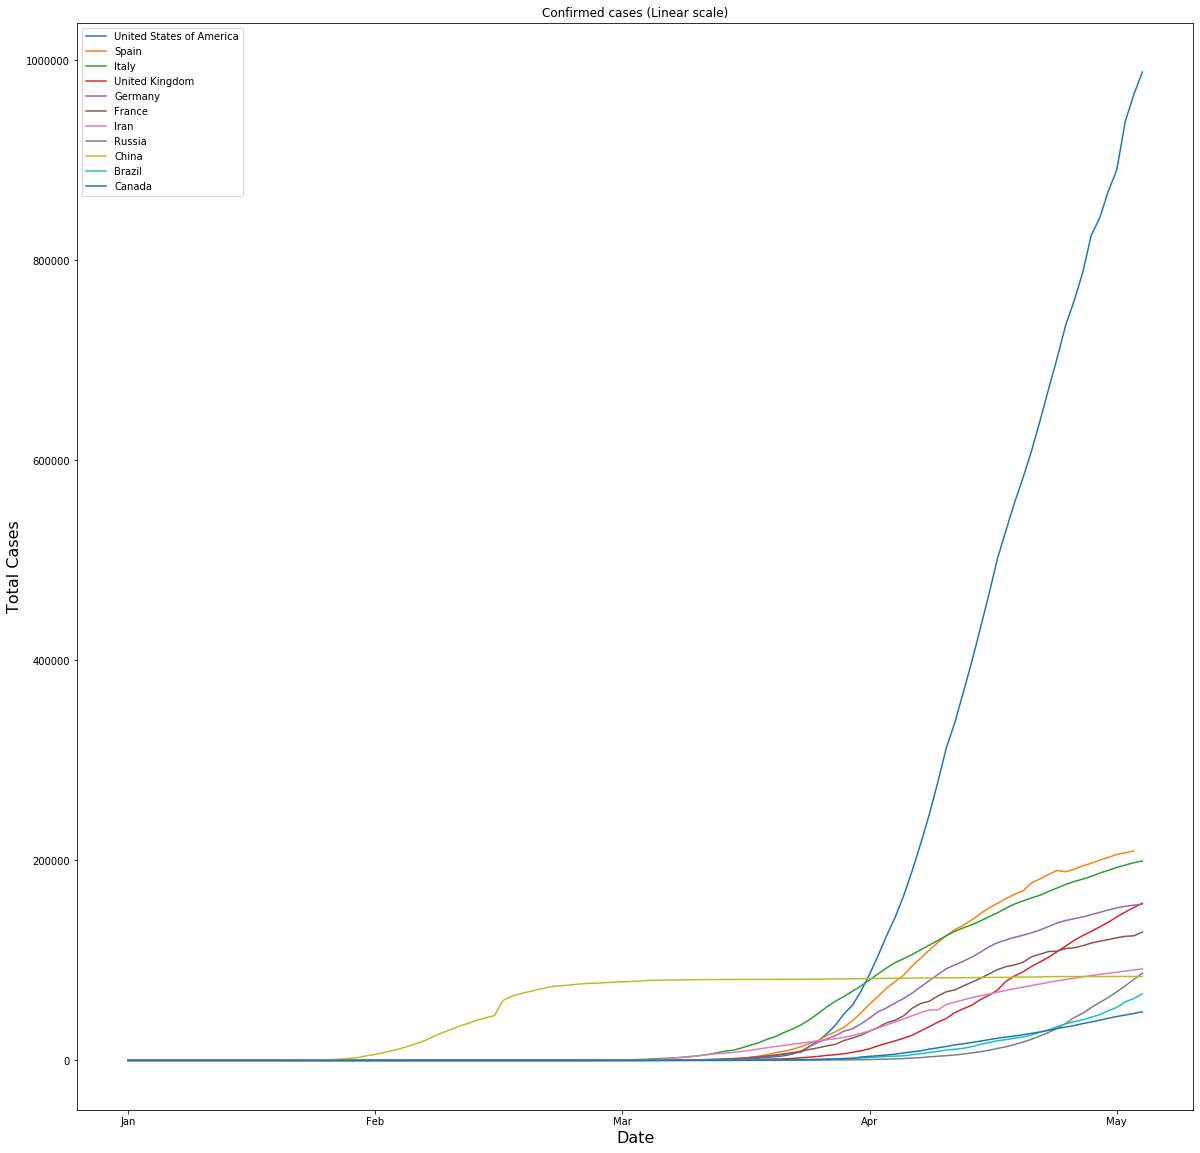

In [211]:
for country in ten_countries_data:
    plt.plot(ten_countries_data[country].index, ten_countries_data[country]["Cumulative Count"], label = country)    
    
plt.xticks(range(0, 119, int(119/4)), ["Jan", "Feb", "Mar", "Apr", "May"])
plt.legend(loc='best')
plt.xlabel("Date", fontsize=16)  
plt.ylabel("Total Cases", fontsize=16)
plt.title("Confirmed cases (Linear scale)")
plt.show()

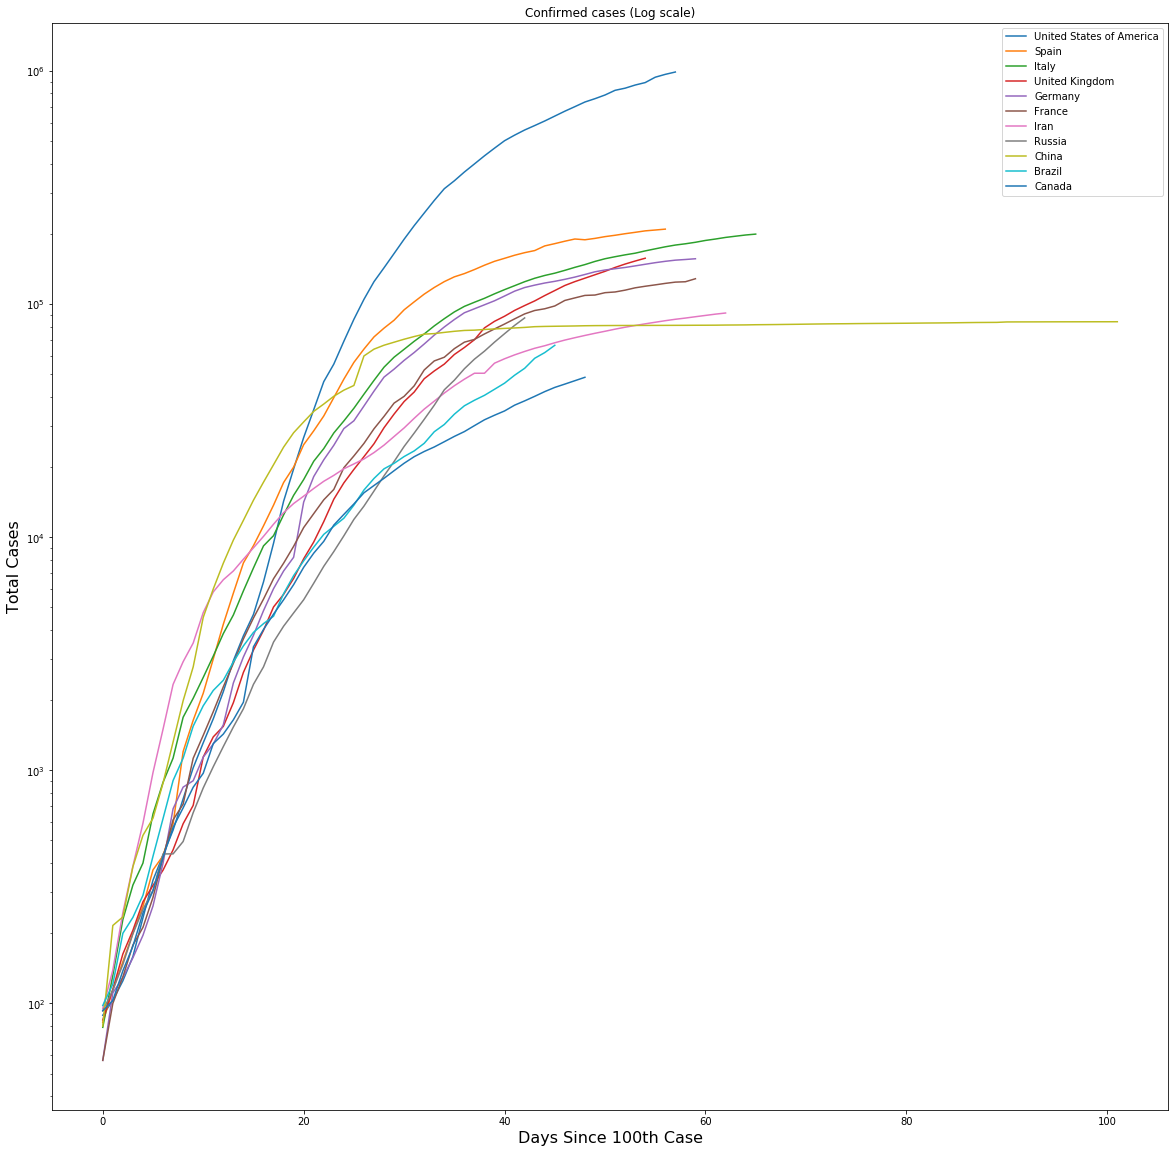

In [212]:
for country in ten_countries_data:
    first_case = np.where(ten_countries_data[country]["Cumulative Count"] < 100)[0]

    if len(first_case) == 0:
        first_case_index = 0
    else:
        first_case_index = first_case[-1]
    
    plt.plot(range(0, len(ten_countries_data[country]) - first_case_index), ten_countries_data[country]["Cumulative Count"][first_case_index:], label = country)    
    
plt.legend(loc='best')
plt.xlabel("Days Since 100th Case", fontsize=16)  
plt.ylabel("Total Cases", fontsize=16)
plt.yscale("log")
plt.title("Confirmed cases (Log scale)")
plt.rcParams["figure.figsize"]=20,20
plt.show()